# Predicting the Programming Languages of Most Starred Github Repos

## Goal
Build a model that can predict what programming language a repository is, given the text of the README file.

In [5]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

# scraping modules
from requests import get
from bs4 import BeautifulSoup

import unicodedata
import re
import json

from wordcloud import WordCloud

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

import os
import acquire
import prepare

import warnings
warnings.filterwarnings("ignore")

## I. Acquire

Fetch data from local cache using the function `scrape_github_data` from the acquire.py module.

In [130]:
# acquire.scrape_github_data()

In [6]:
df = pd.read_json('final_data.json')

In [7]:
len(df)

676

In [8]:
df.head(1)

,language,readme_contents,repo
0,Python,"# BERT\n\n**\*\*\*\*\* New May 31st, 2019: Who...",google-research/bert


## II. Prep

`prep_articles` function from the prepare.py module performs the following:
 - normalize data by removing non-ascii characters, special characters, numbers, white spaces...
 - tokenize words
 - stem and lemmatize words
 - remove stop words and other extraneous words

> We used the functions commented out below to generate a prepped data frame. Then we save the resulting data frame as a .json file.

In [9]:
# df = df[df.readme_contents.notnull()]
# df = prepare.prep_articles(df)
# df.to_json("prepped_df.json")

In [10]:
df = pd.read_json("prepped15_df.json")
df.head()

,language,original,normalized,stemmed,lemmatized,cleaned
0,Python,"# BERT\n\n**\*\*\*\*\* New May 31st, 2019: Who...",bert new may whole wor...,bert new may whole word mask model thi releas ...,bert new may whole word masking model this rel...,bert new may whole word masking model release ...
10,Python,"<h1 align=""center""><img src=""https://cdn.rawgi...",align center img src https cdn rawgit co...,align center img src http cdn rawgit com jarun...,align center img src http cdn rawgit com jarun...,align center cdn rawgit jarun googler master g...
100,Ruby,![logo](http://i.imgur.com/i2fElxx.png)\n\n__`...,logo http imgur com felxx png xcpret...,logo http imgur com felxx png xcpretti fast an...,logo http imgur com felxx png xcpretty fast an...,imgur felxx xcpretty fast flexible formatter x...
101,Go,# JX \n\nJX is a command line tool for install...,command line tool for installing and using je...,command line tool for instal and use jenkin ht...,command line tool for installing and using jen...,command line tool installing using jenkins jen...
102,JavaScript,"<div align=""center""> \n<table>\n<colgroup>\n<c...",div align center table colgroup col w...,div align center tabl colgroup col width colgr...,div align center table colgroup col width colg...,align center table colgroup col width colgroup...


What are the words we want to exclude?
- http
- banner
- request
- img
- badge
- svg
- www
- com
- png
- welcome
- pr
- style
- flat
- makeapullrequest
- gitpod
- logo
- blue
- green
- brightgreen
- div
- align
- center
- width
- src

Look for documents where there are no programming language indicated.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 504 entries, 0 to 99
Data columns (total 6 columns):
language      504 non-null object
original      504 non-null object
normalized    504 non-null object
stemmed       504 non-null object
lemmatized    504 non-null object
cleaned       504 non-null object
dtypes: object(6)
memory usage: 27.6+ KB


In [12]:
df[df.language.isnull()]

,language,original,normalized,stemmed,lemmatized,cleaned


Since the programming language is necessary to train the model, we will drop these documents from our data set.

## III. Explore

Extract a separate data frame called `dfx` that will be used for exploration. We will only focus on the target variable `language` and the feature variable `cleaned` which contains the content of the readme files.

Below are the questions we want to answer in this phase:
1. What are the most common words in READMEs?
2. What does the distribution of IDFs look like for the most common words?
3. Does the length of the README vary by programming language?
4. Do different programming languages use a different number of unique words?

In [13]:
dfx = df[["language","cleaned"]]

In [14]:
dfx.head()

,language,cleaned
0,Python,bert new may whole word masking model release ...
10,Python,align center cdn rawgit jarun googler master g...
100,Ruby,imgur felxx xcpretty fast flexible formatter x...
101,Go,command line tool installing using jenkins jen...
102,JavaScript,align center table colgroup col width colgroup...


#### A. Distribution of Data, Top Words

In [15]:
value_counts = pd.DataFrame(dfx.language.value_counts(ascending=False))
value_counts

,language
JavaScript,129
Python,83
Java,47
PHP,40
Go,37
Jupyter Notebook,25
HTML,23
Swift,22
TypeScript,20
Ruby,18


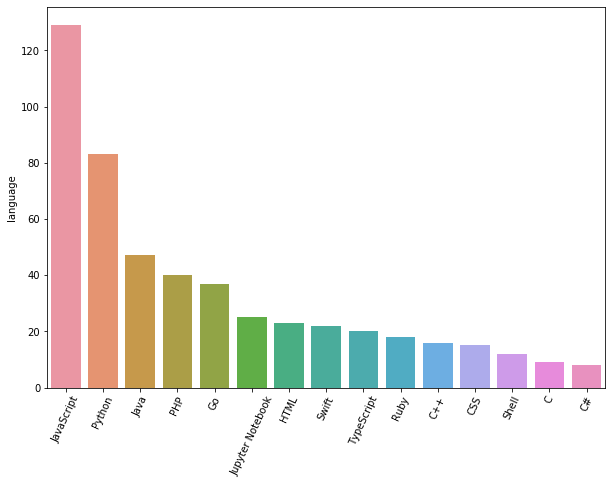

In [16]:
plt.figure(figsize=(10,7))
bar = sns.barplot(x=value_counts.index, y="language", data=value_counts)
bar.set_xticklabels(bar.get_xticklabels(),rotation=65)

plt.show()

Make a variable named `corpus`, which is a pd.Series of all the words in `dfx`. Correspondingly, make a variable named `bag` (i.e., "bag of words") which provides us with a list of all words in one big collection.

In [17]:
corpus = pd.Series(" ".join(dfx.cleaned).split())
bag = " ".join(dfx.cleaned)

(-0.5, 399.5, 199.5, -0.5)

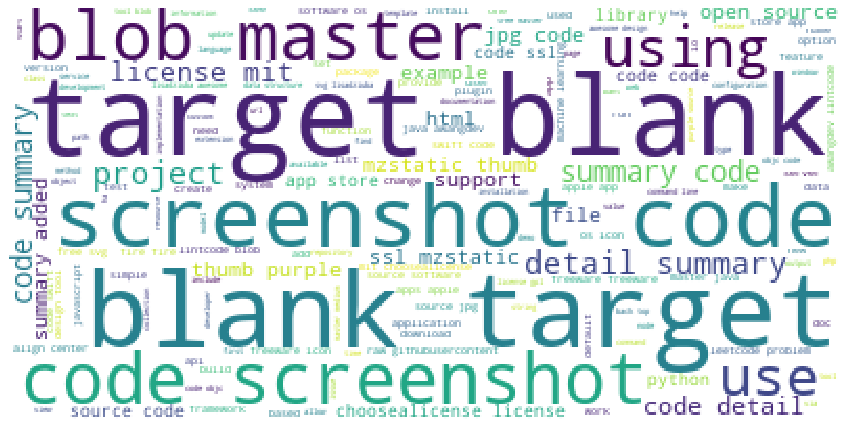

In [18]:
plt.figure(figsize=(15, 8))
img = WordCloud(background_color='white',random_state=1).generate(bag)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

#### C. Common Bigrams

## IV. Model

In [19]:
df.head()

,language,original,normalized,stemmed,lemmatized,cleaned
0,Python,"# BERT\n\n**\*\*\*\*\* New May 31st, 2019: Who...",bert new may whole wor...,bert new may whole word mask model thi releas ...,bert new may whole word masking model this rel...,bert new may whole word masking model release ...
10,Python,"<h1 align=""center""><img src=""https://cdn.rawgi...",align center img src https cdn rawgit co...,align center img src http cdn rawgit com jarun...,align center img src http cdn rawgit com jarun...,align center cdn rawgit jarun googler master g...
100,Ruby,![logo](http://i.imgur.com/i2fElxx.png)\n\n__`...,logo http imgur com felxx png xcpret...,logo http imgur com felxx png xcpretti fast an...,logo http imgur com felxx png xcpretty fast an...,imgur felxx xcpretty fast flexible formatter x...
101,Go,# JX \n\nJX is a command line tool for install...,command line tool for installing and using je...,command line tool for instal and use jenkin ht...,command line tool for installing and using jen...,command line tool installing using jenkins jen...
102,JavaScript,"<div align=""center""> \n<table>\n<colgroup>\n<c...",div align center table colgroup col w...,div align center tabl colgroup col width colgr...,div align center table colgroup col width colg...,align center table colgroup col width colgroup...


### A. TFIDF

Get features using TFIDF

In [20]:
df

,language,original,normalized,stemmed,lemmatized,cleaned
0,Python,"# BERT\n\n**\*\*\*\*\* New May 31st, 2019: Who...",bert new may whole wor...,bert new may whole word mask model thi releas ...,bert new may whole word masking model this rel...,bert new may whole word masking model release ...
10,Python,"<h1 align=""center""><img src=""https://cdn.rawgi...",align center img src https cdn rawgit co...,align center img src http cdn rawgit com jarun...,align center img src http cdn rawgit com jarun...,align center cdn rawgit jarun googler master g...
100,Ruby,![logo](http://i.imgur.com/i2fElxx.png)\n\n__`...,logo http imgur com felxx png xcpret...,logo http imgur com felxx png xcpretti fast an...,logo http imgur com felxx png xcpretty fast an...,imgur felxx xcpretty fast flexible formatter x...
101,Go,# JX \n\nJX is a command line tool for install...,command line tool for installing and using je...,command line tool for instal and use jenkin ht...,command line tool for installing and using jen...,command line tool installing using jenkins jen...
102,JavaScript,"<div align=""center""> \n<table>\n<colgroup>\n<c...",div align center table colgroup col w...,div align center tabl colgroup col width colgr...,div align center table colgroup col width colg...,align center table colgroup col width colgroup...
103,Go,# CDS: Continuous Delivery Service\n\n[![Join ...,cds continuous delivery service join the ...,cd continu deliveri servic join the chat http ...,cd continuous delivery service join the chat h...,cd continuous delivery service join chat gitte...
104,PHP,PHPCI\n=====\n\nPHPCI is a free and open sourc...,phpci phpci free and open source bsd...,phpci phpci free and open sourc bsd licens con...,phpci phpci free and open source bsd license c...,phpci phpci free open source bsd license conti...
105,C#,﻿# Cake\n\n[![NuGet](https://img.shields.io/nu...,cake nuget https img shields nuget ca...,cake nuget http img shield nuget cake svg http...,cake nuget http img shield nuget cake svg http...,cake nuget shield nuget cake svg nuget package...
108,Ruby,# Hound\n\n[![Build Status](https://circleci.c...,hound build status https circleci com ...,hound build statu http circleci com houndci ho...,hound build status http circleci com houndci h...,hound build status circleci houndci hound svg ...
109,Go,"<p align=""center"">\n <img align=""center"" sr...",align center img align center src d...,align center img align center src doc asset im...,align center img align center src doc asset im...,align center align center doc asset blue svg w...


In [21]:
df_dict = dict(df.cleaned)

In [22]:
tfidf = TfidfVectorizer()
sparse = tfidf.fit_transform(df_dict.values())

In [23]:
sparse_matrix = pd.DataFrame(sparse.todense(),columns=tfidf.get_feature_names())

In [24]:
sparse_matrix.head()

,aaa,aaaa,aaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaa,aaaaj,aaafj,aaai,aab,aabac,...,zybuluo,zydeco,zydis,zypper,zysuper,zyszys,zythum,zythumbnailtableview,zzan,zzmark
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.006662,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X = tfidf.fit_transform(df.cleaned)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)


### B. Split Train-Test

In [25]:
X = tfidf.fit_transform(df.cleaned)
y = df.language

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

#### Logistic Regression

In [27]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Decision Tree Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

---

---

In [28]:
df = pd.read_json("prepped15_df.json")

In [29]:
corpus = pd.Series(" ".join(df.cleaned).split())

In [30]:
df.head(1)

,language,original,normalized,stemmed,lemmatized,cleaned
0,Python,"# BERT\n\n**\*\*\*\*\* New May 31st, 2019: Who...",bert new may whole wor...,bert new may whole word mask model thi releas ...,bert new may whole word masking model this rel...,bert new may whole word masking model release ...


In [31]:
js_words = ' '.join(df[df.language == 'JavaScript'].cleaned).split()

In [32]:
len(js_words)

139923

## FUNC - generate_bow

In [33]:
def generate_bow(programming_language, df=df):
    bow = ' '.join(df[df.language == programming_language].cleaned).split()
    bow = pd.DataFrame(pd.Series(bow).value_counts())
    bow.reset_index(inplace=True)
    bow.columns = ["word","frequency"]
    max_freq = bow.frequency.max()
    bow = bow.assign(augmented_frequency = bow.frequency/max_freq)
    bow = bow.assign(language = programming_language)
    bow = bow.assign(tally = 1)
    bow = bow[bow.augmented_frequency >= 0.1]
    return bow

In [34]:
def concat_all_bow():
    python_bow = generate_bow("Python")
    ruby_bow = generate_bow("Ruby")
    go_bow = generate_bow("Go")
    js_bow = generate_bow("JavaScript")
    php_bow = generate_bow("PHP")
    csharp_bow = generate_bow("C#")
    shell_bow = generate_bow("Shell")
    swift_bow = generate_bow("Swift")
    typescript_bow = generate_bow("TypeScript")
    html_bow = generate_bow("HTML")
    java_bow = generate_bow("Java")
    jn_bow = generate_bow("Jupyter Notebook")
    css_bow = generate_bow("CSS")
    cpp_bow = generate_bow("C++")
    c_bow = generate_bow("C")
    return pd.concat([python_bow,ruby_bow,go_bow,js_bow,php_bow,csharp_bow,shell_bow,swift_bow,typescript_bow,html_bow,java_bow,jn_bow,css_bow,cpp_bow,c_bow])

In [35]:
common_bow = concat_all_bow()
common_bow.head(1)

,word,frequency,augmented_frequency,language,tally
0,python,1949,1.0,Python,1


In [36]:
rarity_matrix = pd.pivot_table(common_bow,columns="language",index="word",aggfunc="sum",values="tally",fill_value=0)

In [37]:
rarity_matrix.head(5)

language,C,C#,C++,CSS,Go,HTML,Java,JavaScript,Jupyter Notebook,PHP,Python,Ruby,Shell,Swift,TypeScript
word,,,,,,,,,,,,,,,
accessibility,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
acer,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
action,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
activation,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
add,1,1,0,1,1,0,0,0,0,1,1,1,1,0,1


In [38]:
rarity_matrix.index

Index(['accessibility', 'acer', 'action', 'activation', 'add', 'added',
       'addons', 'admin', 'aerial', 'air',
       ...
       'written', 'wwdc', 'xcode', 'xcpretty', 'xps', 'yaml', 'yarn', 'yml',
       'youtube', 'zsh'],
      dtype='object', name='word', length=672)

In [39]:
rarity_matrix = rarity_matrix.assign(presence = rarity_matrix.sum(axis=1))

In [71]:
rarity_matrix = rarity_matrix.assign(rarity_score = (15/rarity_matrix.presence)/(rarity_matrix.presence.max()))

In [73]:
rarity_matrix

language,C,C#,C++,CSS,Go,HTML,Java,JavaScript,Jupyter Notebook,PHP,Python,Ruby,Shell,Swift,TypeScript,presence,rarity_score
word,,,,,,,,,,,,,,,,,
accessibility,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1.071429
acer,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1.071429
action,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1.071429
activation,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1.071429
add,1,1,0,1,1,0,0,0,0,1,1,1,1,0,1,9,0.119048
added,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1.071429
addons,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1.071429
admin,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1.071429
aerial,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.071429


In [43]:
rarity_matrix.loc["powershell"]

language
C                   0.000000
C#                  1.000000
C++                 0.000000
CSS                 0.000000
Go                  0.000000
HTML                0.000000
Java                0.000000
JavaScript          0.000000
Jupyter Notebook    0.000000
PHP                 0.000000
Python              0.000000
Ruby                0.000000
Shell               0.000000
Swift               0.000000
TypeScript          0.000000
presence            1.000000
rarity_score        1.071429
Name: powershell, dtype: float64

In [44]:
rs_df = pd.DataFrame(rarity_matrix.rarity_score.copy())

In [45]:
rs_df

,rarity_score
word,
accessibility,1.071429
acer,1.071429
action,1.071429
activation,1.071429
add,0.119048
added,1.071429
addons,1.071429
admin,1.071429
aerial,1.071429


In [46]:
common_bow = common_bow.set_index("word")

In [47]:
relevance_matrix = common_bow.join(rs_df)

In [48]:
relevance_matrix = relevance_matrix.groupby(relevance_matrix.index).mean()

In [49]:
relevance_matrix["relevance_rating"] = relevance_matrix.augmented_frequency * relevance_matrix.rarity_score

,frequency,augmented_frequency,tally,rarity_score,relevance_rating
word,,,,,
accessibility,49.000000,0.120988,1.0,1.071429,0.129630
acer,56.000000,0.138272,1.0,1.071429,0.148148
action,65.000000,0.160494,1.0,1.071429,0.171958
activation,44.000000,0.101149,1.0,1.071429,0.108374
add,70.111111,0.156780,1.0,0.119048,0.018664


In [50]:
relevance_matrix.describe()

,frequency,augmented_frequency,tally,rarity_score,relevance_rating
count,672.000000,672.000000,672.0,672.000000,672.000000
mean,126.615503,0.203174,1.0,0.801070,0.162823
std,277.875612,0.137522,0.0,0.365402,0.158006
min,9.000000,0.100000,1.0,0.076531,0.018664
25%,38.000000,0.123810,1.0,0.357143,0.069798
50%,56.000000,0.158572,1.0,1.071429,0.124224
75%,106.000000,0.226391,1.0,1.071429,0.182665
max,3105.000000,1.000000,1.0,1.071429,1.071429


Highly present word AND unique to a specific language

In [51]:
relevance_matrix[relevance_matrix.relevance_rating>1]

,frequency,augmented_frequency,tally,rarity_score,relevance_rating
word,,,,,
assemble,502.0,1.0,1.0,1.071429,1.071429
cpp,884.0,1.0,1.0,1.071429,1.071429
hackintosh,405.0,1.0,1.0,1.071429,1.071429
java,2493.0,1.0,1.0,1.071429,1.071429
powershell,271.0,1.0,1.0,1.071429,1.071429
pre,138.0,1.0,1.0,1.071429,1.071429
webpack,400.0,1.0,1.0,1.071429,1.071429


In [75]:
len(relevance_matrix)

672

In [ ]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Decision Tree Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))